
Bad key "text.kerning_factor" on line 4 in
/home/sufedc_nvidia_newgyh/anaconda/envs/myTorch/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Config loading begin

Data: dae_metric_result

Succeed to read classes file
Succeed to read config file
Config loading is valid
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Date getting begin

Succeeded to get_data
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Begin train
 
Model use LeNet
 
Gpu is used


 20%|██        | 5/25 [01:18<05:25, 16.29s/it]

 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch : 1 - 5
Training_time = 15.73559 s / epoch
Avg_loss_function = 9.524625724554062
Precision = 88.18541548897683 %
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 


 40%|████      | 10/25 [02:25<03:27, 13.81s/it]

 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch : 6 - 10
Training_time = 13.27843 s / epoch
Avg_loss_function = 5.919659465551376
Precision = 92.7784058790277 %
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 


 60%|██████    | 15/25 [03:31<02:12, 13.29s/it]

 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch : 11 - 15
Training_time = 13.27493 s / epoch
Avg_loss_function = 3.643630728125572
Precision = 96.89089881288864 %
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 


 80%|████████  | 20/25 [04:36<01:05, 13.13s/it]

 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch : 16 - 20
Training_time = 13.09301 s / epoch
Avg_loss_function = 2.7180150598287582
Precision = 97.55511588468062 %
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 


100%|██████████| 25/25 [05:42<00:00, 13.71s/it]

 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch : 21 - 25
Training_time = 13.17511 s / epoch
Avg_loss_function = 1.9282993078231812
Precision = 99.25098925946862 %
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
Training time = 13.71274 s / epoch
 
Finish train
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Begin test
 
Gpu is used


Infering time = 0.006958 s / pic
 
Finish test
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 
 
Test Precision = 97.08121827411168 %


KeyboardInterrupt: 

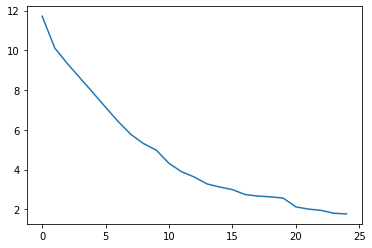

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 14 20:09:47 2020

@author: 12057
"""

from __future__ import print_function

import sys
sys.path.append(r'/home/sufedc_nvidia_newgyh/apex')
from apex import amp

import torch

from torch.autograd import Variable

import torchvision

import torchvision.transforms as transforms

from tqdm import tqdm
import PIL
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from config import Config #获取配置
from Pytorch_nets_channel1 import * #自定义的神经网络
from Data_Augment_New import * #自定义的数据增强方法 对PIL Image
from CV_tricks import * #自定义的CV的tricks
from Data_loader2d import  data_get

"""
epoch: 全部图片迭代一次
iteration: 一个batch迭代一次
"""


#获取数据，并进行预处理和数据增强

def get_data(cfg):
    """
    获取预处理和数据增强后的数据集
    :param: cfg 配置文件
    return trainloader, testloader, data_ok
           训练loader   测试loader  数据是否获得
    """
    print('>' * 80)
    print('Date getting begin')
    print('')
    
    try:
        trainloader, testloader = data_get(cfg)
            
        print('Succeeded to get_data')
        print('>' * 80)
        print(' ')
        print(' ')
        
        return trainloader, testloader, True 
    
    except: #防爆
        
        print('Failed to get_data, stop training')
        print('>' * 80)
        print(' ')
        print(' ')
        
        return None, None, False
           

#模型训练

def train(trainloader, cfg):
    """
    :param: trainloader 训练数据loader
    :param: cfg 配置文件
    return train_loss 各epoch训练损失函数list
    """
    print('>' * 80)    
    print('Begin train')
    print(' ')

    #模型基本配置
    print('Model use {}'.format(cfg.model_name))
    print(' ')
    model = get_model(cfg.model_name, cfg.classes, attention = cfg.attention) #根据模型名载入模型
    
    begin_epoch = 0 #初始epoch

    model.train() #切换到训练模式
      
    if not cfg.distribution:
        #device = torch.device(cfg.device) #选择设备
        try: #有gpu
            #model.cuda(device) #设备选择
            model.cuda()
            gpu = True #是否有gpu
            print('Gpu is used')
        except:#不用gpu
            gpu = False
            print('Cpu is used')
    else:
        gpu = True #是否有gpu
        print('Gpu is used')

    if cfg.pretrain: #如果有预训练
        model_info = torch.load(os.path.join(cfg.pretrain, 'model_{}_state.pkl'.format(cfg.model_name)))
        
    criterion = torch.nn.CrossEntropyLoss() #损失函数方法：交叉熵（自带softmax）
    alpha = cfg.alpha if not cfg.pretrain else model_info['alpha'] #初始学习率，有预处理以预处理为准
    optimizer = torch.optim.SGD(model.parameters(), momentum = cfg.momentum, lr = alpha, weight_decay = cfg.weight_decay) #迭代方法SGD
                                                           #动量              初始学习率            权重衰减趋势
    #optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8, weight_decay = cfg.weight_decay) #迭代方法Adam
                                                       #学习率      梯度及梯度平方系数   分母防零修正           权重衰减系数
                                                       
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10) #学习率衰减(余弦退火)
                                                        #0, T_max下降，T_max到2 * T_max上升
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda = lambda step:np.sin(step) / step) #自己设定,函数输入为步数
                                                                    #自己设定函数
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [20, 80], gamma = 0.9) #分段式衰减
                                                                #设定变化点，遇到该点变化  衰减系数
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99) #指数衰减，每个epoch
                                                                   #衰减系数
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = cfg.lr_decay, patience = 5, verbose = False, threshold = 0.0001, threshold_mode = 'rel', cooldown = 0, min_lr = 0, eps = 1e-08) #自适应
                                                                     #检测loss减小            衰减系数       容忍次数        是否print         变化阈值范围        rel比例 abs值           冷却时间      最小lr  效果较差不变                                  
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = cfg.lr_step, gamma = cfg.lr_decay) #学习率线性衰减
                                                                #衰减步长         衰减系数 lr *= lr_decay
    if not cfg.pretrain: #如果预训练
        model.apply(initialize_weights) #模型初始化，内置初始化，均匀分布
    
    if gpu:
        model.cuda()
        model, optimizer = amp.initialize(model, optimizer, opt_level = "O1", verbosity = 0) #混合精度模型
                                              #Oo fp32, O1混合, O2几乎fp16, O3 fp16   
    if cfg.distribution:
        model = torch.nn.DataParallel(model, device_ids = list(cfg.distribution))
        
    if cfg.pretrain: #如果有预训练
        model_info = torch.load(os.path.join(cfg.pretrain, 'model_{}_state.pkl'.format(cfg.model_name)))
        model.load_state_dict(model_info['state_dict']) #加载训练出的模型
        begin_epoch = model_info['epoch'] + 1        
        if not cfg.mix_up:
            best_correct = model_info['best_correct']
        train_loss = model_info['train_loss']
    else:
        best_correct = 0 #最优的正确数
        train_loss = []
    
    total_start_time = time.time() #记录时间
    start_time = time.time() #记录时间
    
    for epoch in tqdm(range(begin_epoch, cfg.epoch_num)): #迭代全图
    #for epoch in range(1, cfg.epoch_num + 1): #迭代全图  
        correct = 0 #正确的图片数量  
        total = 0 #图片总数
        
        train_loss_i = 0 #第i次epoch损失
        for batch_idx, (imgs, classes) in enumerate(trainloader): #迭代批次
            #批数       图片    类别 
            
            #one-hot label 化：(交叉熵里面自动有)
            #classes = torch.zeros(cfg.batch_size, len(cfg.classes)).scatter_(1, classes.view(len(classes),1), 1)
                                                                   #稀疏化 维度       值                  对应标签值           
            
            if cfg.mix_up:  #mix_up策略
                imgs, classes_a, classes_b, lam = mix_up_data(imgs, classes)  #非one-hot label数据mix-up
                if gpu: #用gpu
                    imgs, classes_a, classes_b = imgs.cuda(), classes_a.cuda(), classes_b.cuda() #将数据移到GPU上          
                inputs, targets_a, targets_b = Variable(imgs), Variable(classes_a),  Variable(classes_b) #变量化输入x,y_a,y_b
                """
                imgs, classes = mix_up_onehot_data(imgs, classes) #one-hot label数据mix-up
                if gpu: #用gpu
                    imgs, classes = imgs.cuda(), classes.cuda() #将数据移到GPU上
                inputs, targets = Variable(imgs), Variable(classes)  #变量化输入x,y
                """
            else: #没用mix_up策略
                if gpu: #用gpu
                    imgs, classes = imgs.cuda(), classes.cuda() #将数据移到GPU上
                inputs, targets = Variable(imgs), Variable(classes)  #变量化输入x,y
         
            optimizer.zero_grad()   # 先将optimizer梯度先置为0
            
            outputs = model(inputs) #前向传播
            #outputs = model.forward(inputs) #等价效果
            
            if cfg.mix_up: #如果mix_up
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b) # 计算mix-up损失函数
            else: #如果没mix_up
                loss = criterion(outputs, targets) #损失函数
                
            #loss = criterion(outputs, targets)
            
            if gpu:
                with amp.scale_loss(loss, optimizer) as scaled_loss:#采用混合精度模型         
                    scaled_loss.backward() 
            else:
                loss.backward()  #反向传播，计算梯度
            #loss.backward()  #反向传播，计算梯度
            
            optimizer.step() #更新参数
        
            train_loss_i += loss.data.item()#记录每次训练Loss, 必须loss.data[0]
            
            if not cfg.mix_up: #没有mix_up下才有中间结果
                _, predicted = torch.max(outputs.data, dim = 1) #获得预测结果，结果为批次数据, 所以行最大(一行一个结果)
                correct += predicted.eq(targets.data).cpu().sum().item() #计算正确的图片数，cpu上算,.tensor.item()获取值
                
            total += inputs.size(0)#图片数加总(size第一维为批大小), size为大小
        
        scheduler.step() #学习率记录step      
        train_loss.append(train_loss_i) #记录每轮的损失函数值
        precision = 100. * correct / total #准确率 
    
        if  epoch % 5 == 4: #每五次迭代            
            end_time = time.time() #记录时间
            
            #展示模型训练状态
            print(' ')
            print('>' * 80)    
            print('Epoch : {} - {}'.format(epoch - 3, epoch + 1))
            print('Training_time = {} s / epoch'.format(str( (end_time - start_time) / 5 )[:8]) )
            print('Avg_loss_function = {}'.format(np.mean(train_loss[-5:])))
            if not cfg.mix_up:
                print('Precision = {} %'.format(precision))            
            print('>' * 80)
            print(' ')
            
            if not cfg.mix_up and epoch / cfg.epoch_num > 0.1 and correct >= best_correct: #预热10%迭代, 更好的模型，mix_up下没法比较
                best_correct = correct #更新最优结果
                torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_correct': best_correct,
                            'train_loss': train_loss, 'alpha': optimizer.state_dict()['param_groups'][0]['lr']}, #记录迭代次数，状态字典，最好结果, 损失函数list, 学习率
                            os.path.join(cfg.save_path, 'model_{}_state.pkl'.format(cfg.model_name))) #最好的结果(覆盖原来的)
            
            if cfg.mix_up:
                torch.save({'epoch': epoch, 'state_dict': model.state_dict(),
                            'train_loss': train_loss, 'alpha': optimizer.state_dict()['param_groups'][0]['lr']}, #记录迭代次数，状态字典，最好结果, 损失函数list, 学习率
                            os.path.join(cfg.save_path, 'model_{}_state.pkl'.format(cfg.model_name)))
                
                #torch.save(model.state_dict(), os.path.join(cfg.save_path, 'model_{}_state.pkl'.format(cfg.model_name))) #最好的结果(覆盖原来的)
                #保存中间最好的模型(以后可以再训练) 保存模型所有信息，读取时要载入框架
                #torch.save(model, './model_{}.pkl'.format(cfg.model_name)) #保存模型信息，读取时直接读取 等价

            start_time = time.time() #更新时间
            
        torch.cuda.empty_cache() #清理显存
        
    if not os.path.exists(os.path.join(cfg.save_path, 'model_{}_state.pkl'.format(cfg.model_name))): #mix_up下 或者没更好结果 下保存最后结果
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_correct': best_correct, 
                    'train_loss': train_loss, 'alpha': optimizer.state_dict()['param_groups'][0]['lr']}, #记录迭代次数，状态字典，最好结果, 损失函数list, 学习率
                    os.path.join(cfg.save_path, 'model_{}_state.pkl'.format(cfg.model_name))) #最好的结果(覆盖原来的)
 
    total_end_time = time.time() #记录时间           
    
    print('Training time = {} s / epoch'.format( str( (total_end_time - total_start_time) / cfg.epoch_num )[:8] ) )
    print(' ')
    print('Finish train')
    print('>' * 80)    
    print(' ')
    print(' ')
    
    return train_loss

    
#模型测试
#模型测试
def test(testloader, cfg):
    """
    :param: testloader 测试数据loader
    :param: cfg 配置文件
    return: precision 准确率
    """
    print('>' * 80)
    print('Begin test')
    print(' ')

    #载入模型结构   
    model = get_model(cfg.model_name, cfg.classes, attention = cfg.attention) #根据模型名载入模型
    if cfg.distribution:
        model = torch.nn.DataParallel(model, device_ids = list(cfg.distribution))  
    model_info = torch.load(os.path.join(cfg.save_path, 'model_{}_state.pkl'.format(cfg.model_name))) #获取字典
    plt.plot(model_info['train_loss'])
    model.load_state_dict(model_info['state_dict']) #加载训练出的模型
    
    #model.load_state_dict(torch.load(os.path.join(cfg.save_path, 'model_{}_state.pkl'.format(cfg.model_name)))) #加载训练出的模型
    #model = torch.load(r'./model_{}.pkl'.format(cfg.model_name)) 等价
    
    model.eval() #测试，不改变权重
    
    test_list = pd.read_json(r'./test_list.json', orient = 'index')

    device = torch.device(cfg.device) #选择设备
    try: #用gpu
        model.cuda(device) #设备选择
        gpu = True #是否有gpu
        print('Gpu is used')
    except:#不用gpu
        gpu = False
        print('Cpu is used')
    
    correct = 0 #正确数
    total = 0 #图片总数
    wronglist = pd.DataFrame(columns = ['index', 'type', 'path']) #分错序号
    #wronglist = []
    predict_list = []
    with torch.no_grad(): #不进行反向传播, 减少内存
        
        start_time = time.time() #记录时间
        
        for idx, (imgs, classes) in enumerate(testloader): #遍历图片
           #索引  图片   类别
           if gpu:#用gpu
               imgs, classes = imgs.cuda(), classes.cuda()   # 将数据移到GPU上
           inputs, targets = Variable(imgs), Variable(classes) #变量化输入x,y
           
           outputs = model(inputs) #运行模型(获得结果)
           
           _, predicted = torch.max(outputs.data, dim = 1) #获得预测结果，结果为批次数据, 所以行最大(一行一个结果)
           #predict_list.append(predicted)
           correct += predicted.eq(targets.data).cpu().sum().item() #正确数,cpu上算
                   
           if predicted.eq(targets.data).cpu().sum().item() != 1: #如果判断错
               #wronglist.append((idx, classes))
                wronglist.loc[len(wronglist)] = test_list.loc[idx]
                #print(outputs.data)
                
           total += targets.size(0) #图片数加总(size第一维为批大小), size为大小

        end_time = time.time()
     
        precision = 100. * correct / total #准确率
        
        torch.cuda.empty_cache() #清理显存
    
    json_wrong = wronglist.to_json(orient = 'index')
    with open(r'./wronglist.json', 'w') as jsonFile:
         jsonFile.write(json_wrong)
    
    print('Infering time = {} s / pic'.format( str( (end_time - start_time) / total )[:8] ) )
    print(' ')
    print('Finish test')
    print('>' * 80)    
    print(' ')
    print(' ')
    
    print('Test Precision = {} %'.format(precision))   
    
    #print(predict_list)
    
    return precision, wronglist



def main(config_path):
    """
    主函数, 完成数据载入和模型训练 + 测试
    :param: config_path config路径
    return: train_loss,        precision,       wronglist       
            各epcoh下训练损失   测试准确性       错判断序号列表
    """
    torch.backends.cudnn.benchmark = True 
    cfg = Config(config_path) #获取配置文件
    #if cfg.distribution:
        #torch.distributed.init_process_group(backend = 'nccl', init_method = ,world_size = cfg.distribution)
    trainloader, testloader, data_ok = get_data(cfg) #获取数据并进行数据预处理和增强
    if data_ok:
        train_loss = train(trainloader, cfg) #模型训练
        precision, wronglist = test(testloader, cfg) #模型测试
    
        return train_loss, precision, wronglist 
    
    else:
        return None, None, None


if __name__ == "__main__":        
    train_loss, precision, wronglist = main(r'./config_cnn_dae.yml')
    while True:
        pass
    

In [3]:
wronglist

,index,type,path
0,3,xinguan,./DAE_metric_data/xin guan/xinguan_YANXIUFANG_...
1,62,xinguan,./DAE_metric_data/xin guan/xinguan_1018_303-Ch...
2,321,xinguan,./DAE_metric_data/xin guan/xinguan_CAOWENQIAO_...
3,434,xinguan,./DAE_metric_data/xin guan/xinguan_ZHANGDEJUN_...
4,493,xinguan,./DAE_metric_data/xin guan/xinguan_1016_302-Ch...
5,742,xinguan,./DAE_metric_data/xin guan/xinguan_1022_301-Ch...


In [13]:
wronglist

,index,type,path
0,3,xinguan,./DAE_metric_data/xin guan/xinguan_YANXIUFANG_...
1,62,xinguan,./DAE_metric_data/xin guan/xinguan_1018_303-Ch...
2,130,xinguan,./DAE_metric_data/xin guan/xinguan_PENGFENG_ba...
3,321,xinguan,./DAE_metric_data/xin guan/xinguan_CAOWENQIAO_...
4,434,xinguan,./DAE_metric_data/xin guan/xinguan_ZHANGDEJUN_...
5,493,xinguan,./DAE_metric_data/xin guan/xinguan_1016_302-Ch...
6,525,xinguan,./DAE_metric_data/xin guan/xinguan_1004_2-ZS C...
7,742,xinguan,./DAE_metric_data/xin guan/xinguan_1022_301-Ch...
